In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm

sc.settings.n_jobs = 8
sc.set_figure_params(figsize=(5,5), dpi_save=300, dpi=100, frameon=False)
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Arial"
%config InlineBackend.figure_format = 'retina'

In [2]:
adata = sc.read('/Users/pax/Library/CloudStorage/OneDrive-KarolinskaInstitutet/PhD/smrt3ex/Notebook/Results/01_adata_all.h5ad')

In [379]:
adata_drg1 = adata[adata.obs.Description.str.contains('DRG')].copy()

In [3]:
adata_drg = adata[adata.obs.Description.str.contains('DRG')].copy()
adata_drg.var.Symbols = adata_drg.var.Symbols.astype(str)
adata_drg.var.set_index('Symbols', inplace=True)
adata_drg.var_names_make_unique()

In [4]:
strain_dict = dict(zip(adata_drg.obs.Description.cat.categories, ['BafCreRnase4ff','BafCreRnase4ff','WT','WT','Prdm12CreRnase4ff']))
description_edit_dict = dict(zip(adata_drg.obs.Description.cat.categories, ['BafCreRnase4ff-1','BafCreRnase4ff-2','WT-1','WT-2','Prdm12CreRnase4ff']))
adata_drg.obs['Strains'] = adata_drg.obs.Description.map(strain_dict)
adata_drg.obs['Description_edit'] = adata_drg.obs.Description.map(description_edit_dict)
adata_drg.obs.PlateBarcode = adata_drg.obs.PlateBarcode.astype(int).astype(str).astype('category')

In [7]:
sc.pp.filter_cells(adata_drg, min_genes=200)
sc.pp.filter_genes(adata_drg, min_cells=20)

In [8]:
adata_drg.var['mt'] = adata_drg.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
adata_drg.var['rb'] = adata_drg.var_names.str.startswith(('Rps','Rpl')) # annotate the group of ribosomal genes as 'rb'
sc.pp.calculate_qc_metrics(adata_drg, qc_vars=['mt','rb'], percent_top=None, log1p=False, inplace=True)

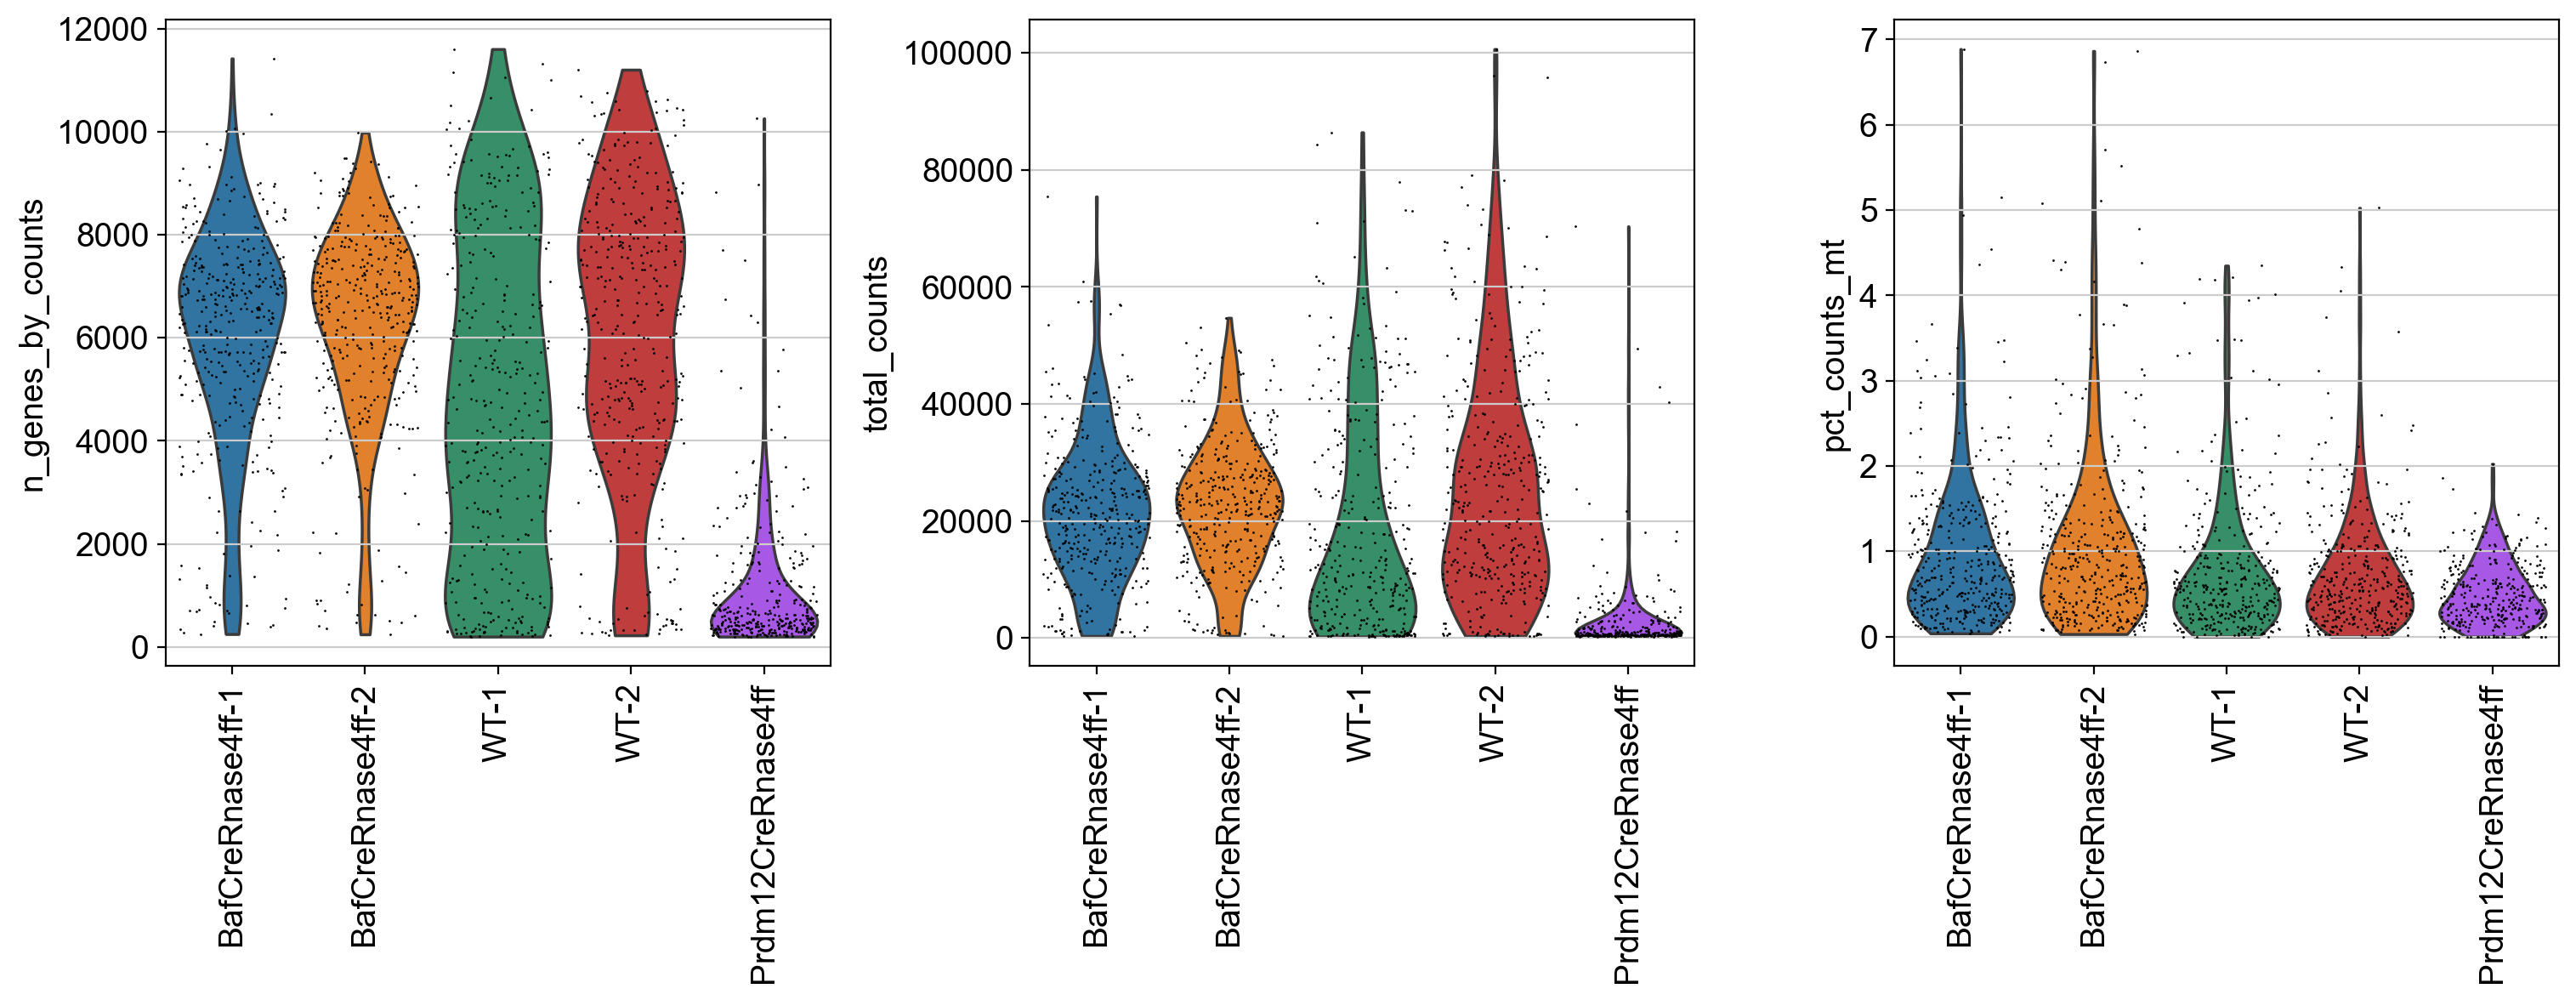

In [9]:
sc.pl.violin(adata_drg, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, groupby='Description_edit', rotation=90)

In [10]:
adatas = {k: adata_drg[adata_drg.obs.Strains == k].copy() for k in adata_drg.obs.Strains.unique()}

In [11]:
sc.pp.filter_cells(adatas['BafCreRnase4ff'], min_genes=3000)
sc.pp.filter_cells(adatas['WT'], min_genes=2000)
sc.pp.filter_cells(adatas['Prdm12CreRnase4ff'], min_genes=4000)

In [12]:
adata_drg = sc.concat(list(adatas.values()), join='outer', merge='same')

In [13]:
adata_drg = adata_drg[(adata_drg.obs.pct_counts_mt < 2) & (adata_drg.obs.pct_counts_rb < 2)].copy()

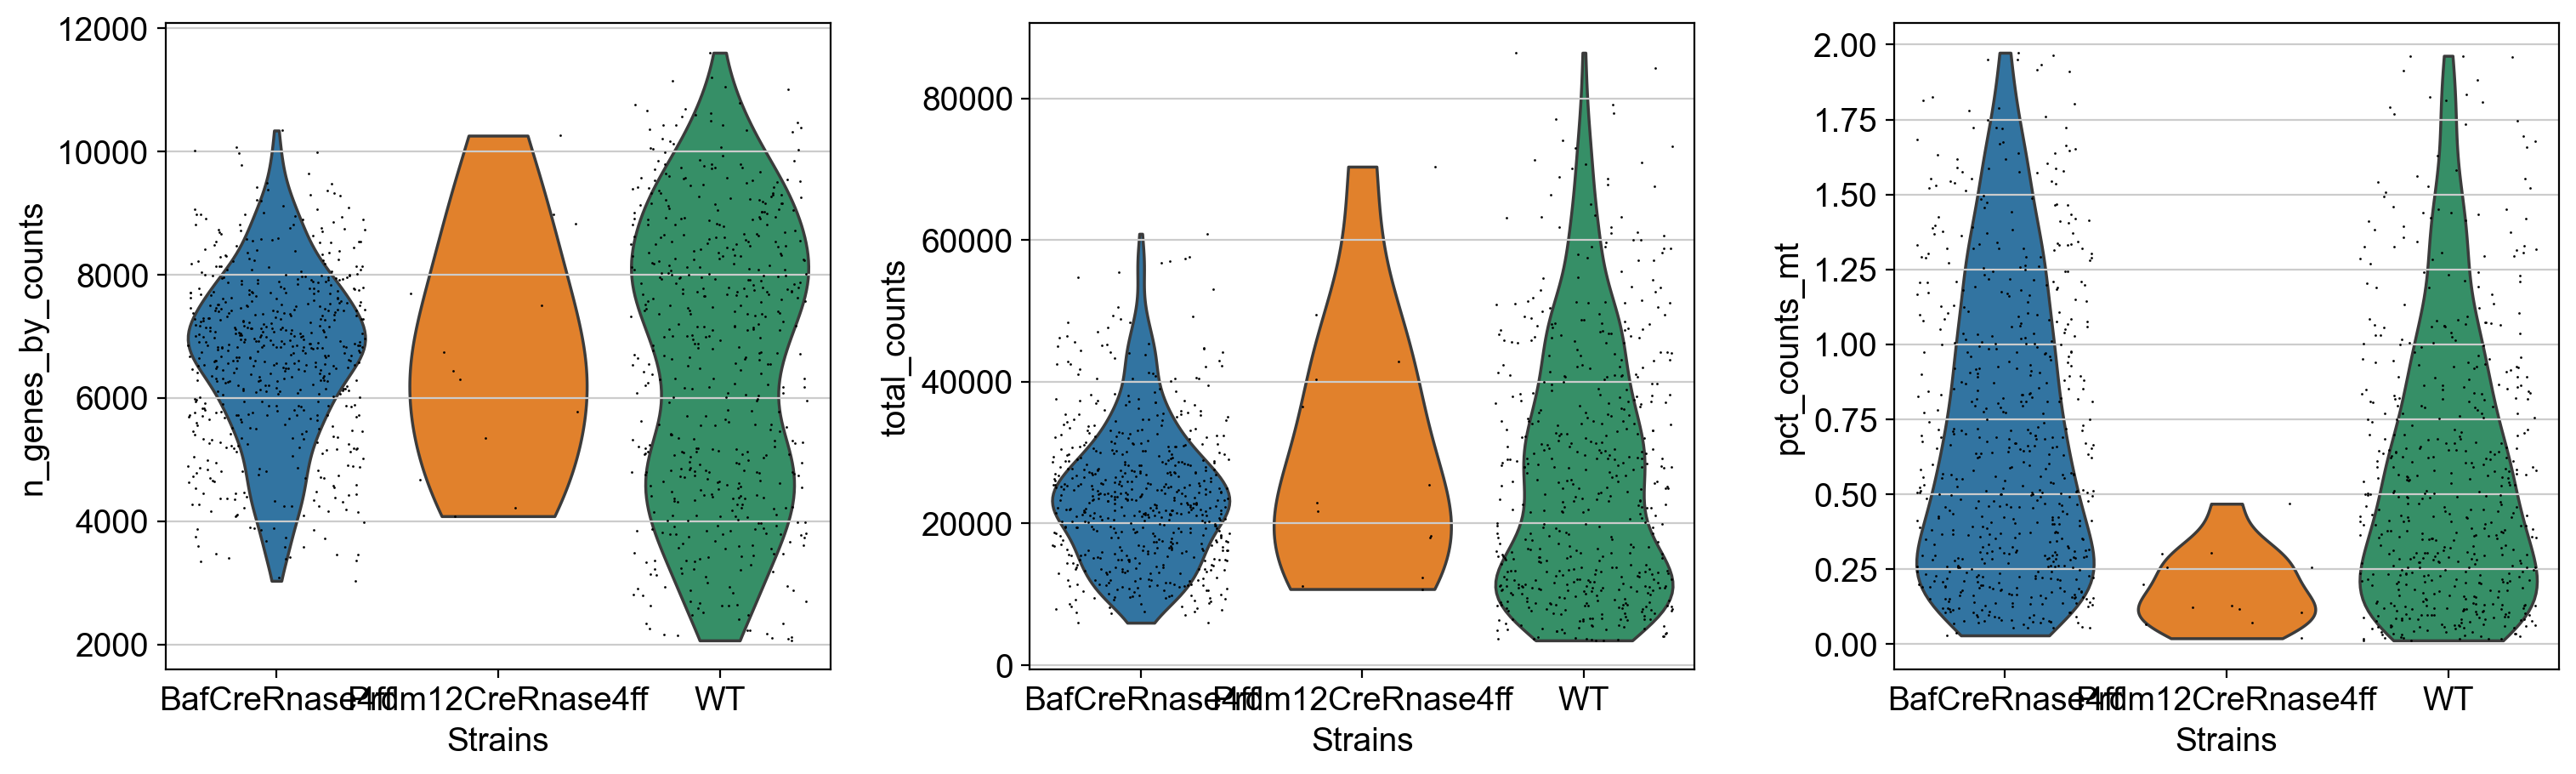

In [14]:
sc.pl.violin(adata_drg, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, groupby='Strains')

In [361]:
adata_drg.obs.Strains.value_counts()

BafCreRnase4ff       586
WT                   514
Prdm12CreRnase4ff     13
Name: Strains, dtype: int64

In [15]:
adata_drg.layers['counts'] = adata_drg.layers['umi'].copy()

In [16]:
sc.pp.normalize_total(adata_drg)
sc.pp.log1p(adata_drg)
adata_drg.layers['log_norm'] = adata_drg.X.copy()

In [17]:
sc.pp.highly_variable_genes(adata_drg, n_top_genes=3000, flavor='seurat_v3', layer='umi')

In [18]:
adata_drg.obsm['X_pca'] = sc.tl.pca(sc.pp.scale(adata_drg.layers['log_norm']))
sc.pp.neighbors(adata_drg, metric='cosine')
sc.tl.umap(adata_drg, min_dist=0.3)
sc.tl.leiden(adata_drg, resolution=0.5)

/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_17951/2080770798.py:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_drg, resolution=0.5)


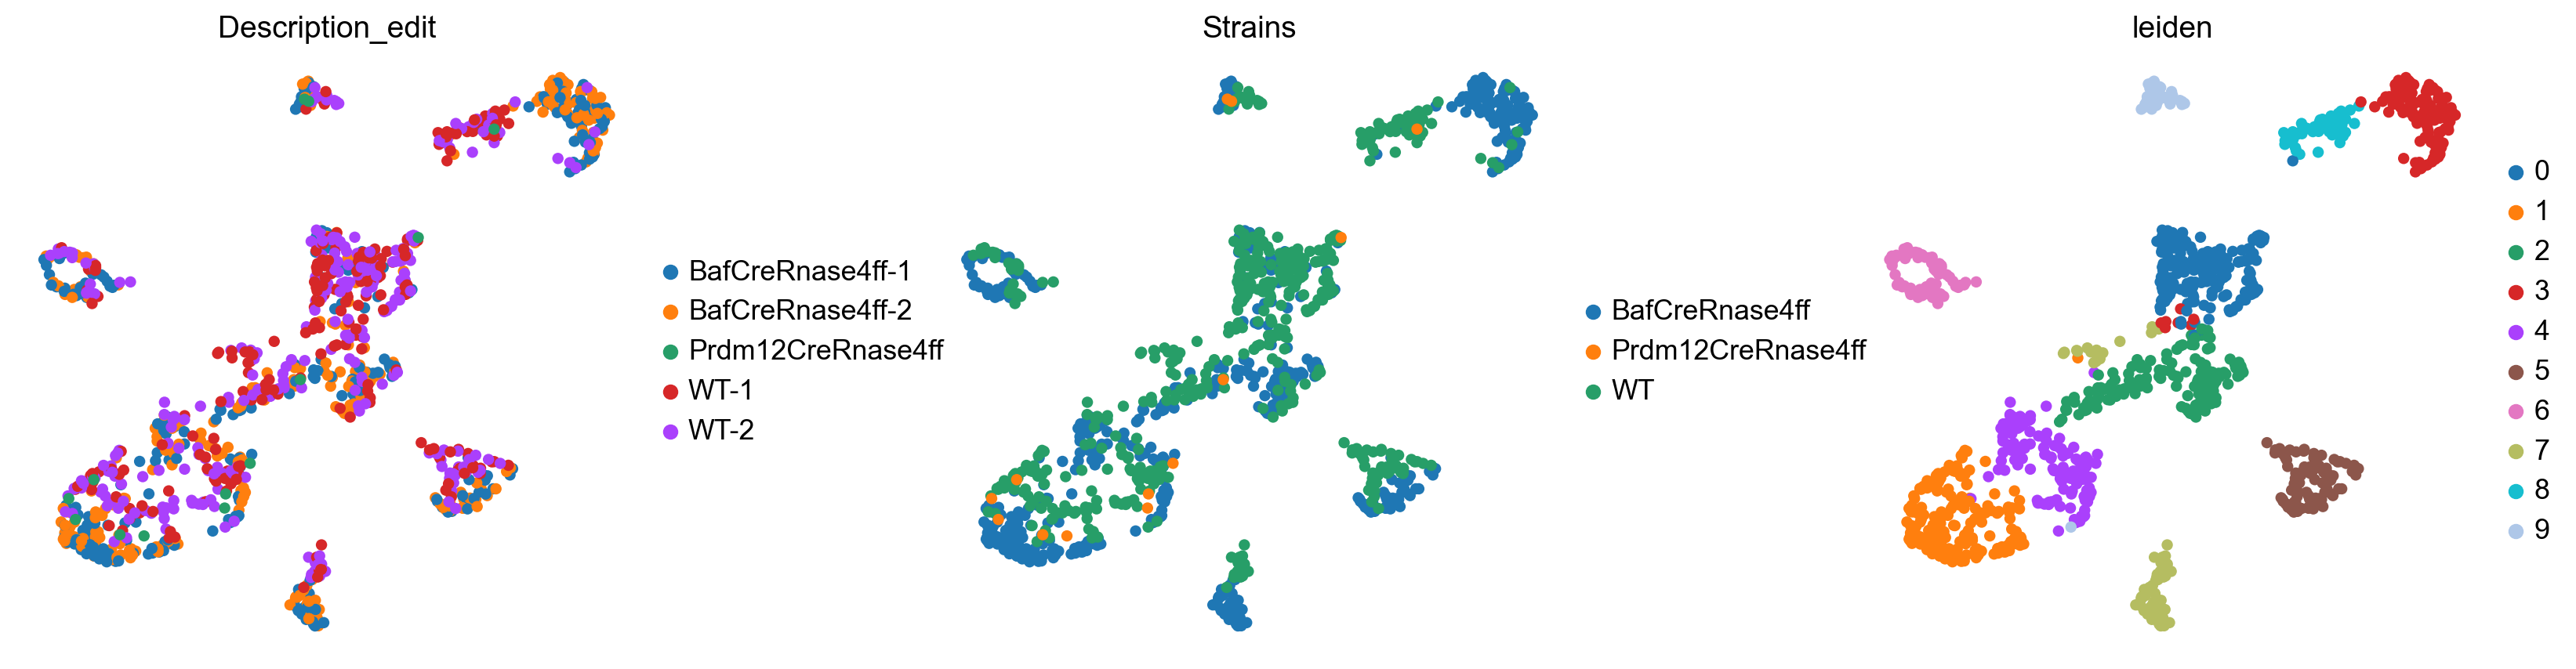

In [19]:
sc.pl.umap(adata_drg, color=['Description_edit','Strains','leiden'], wspace=0.35)

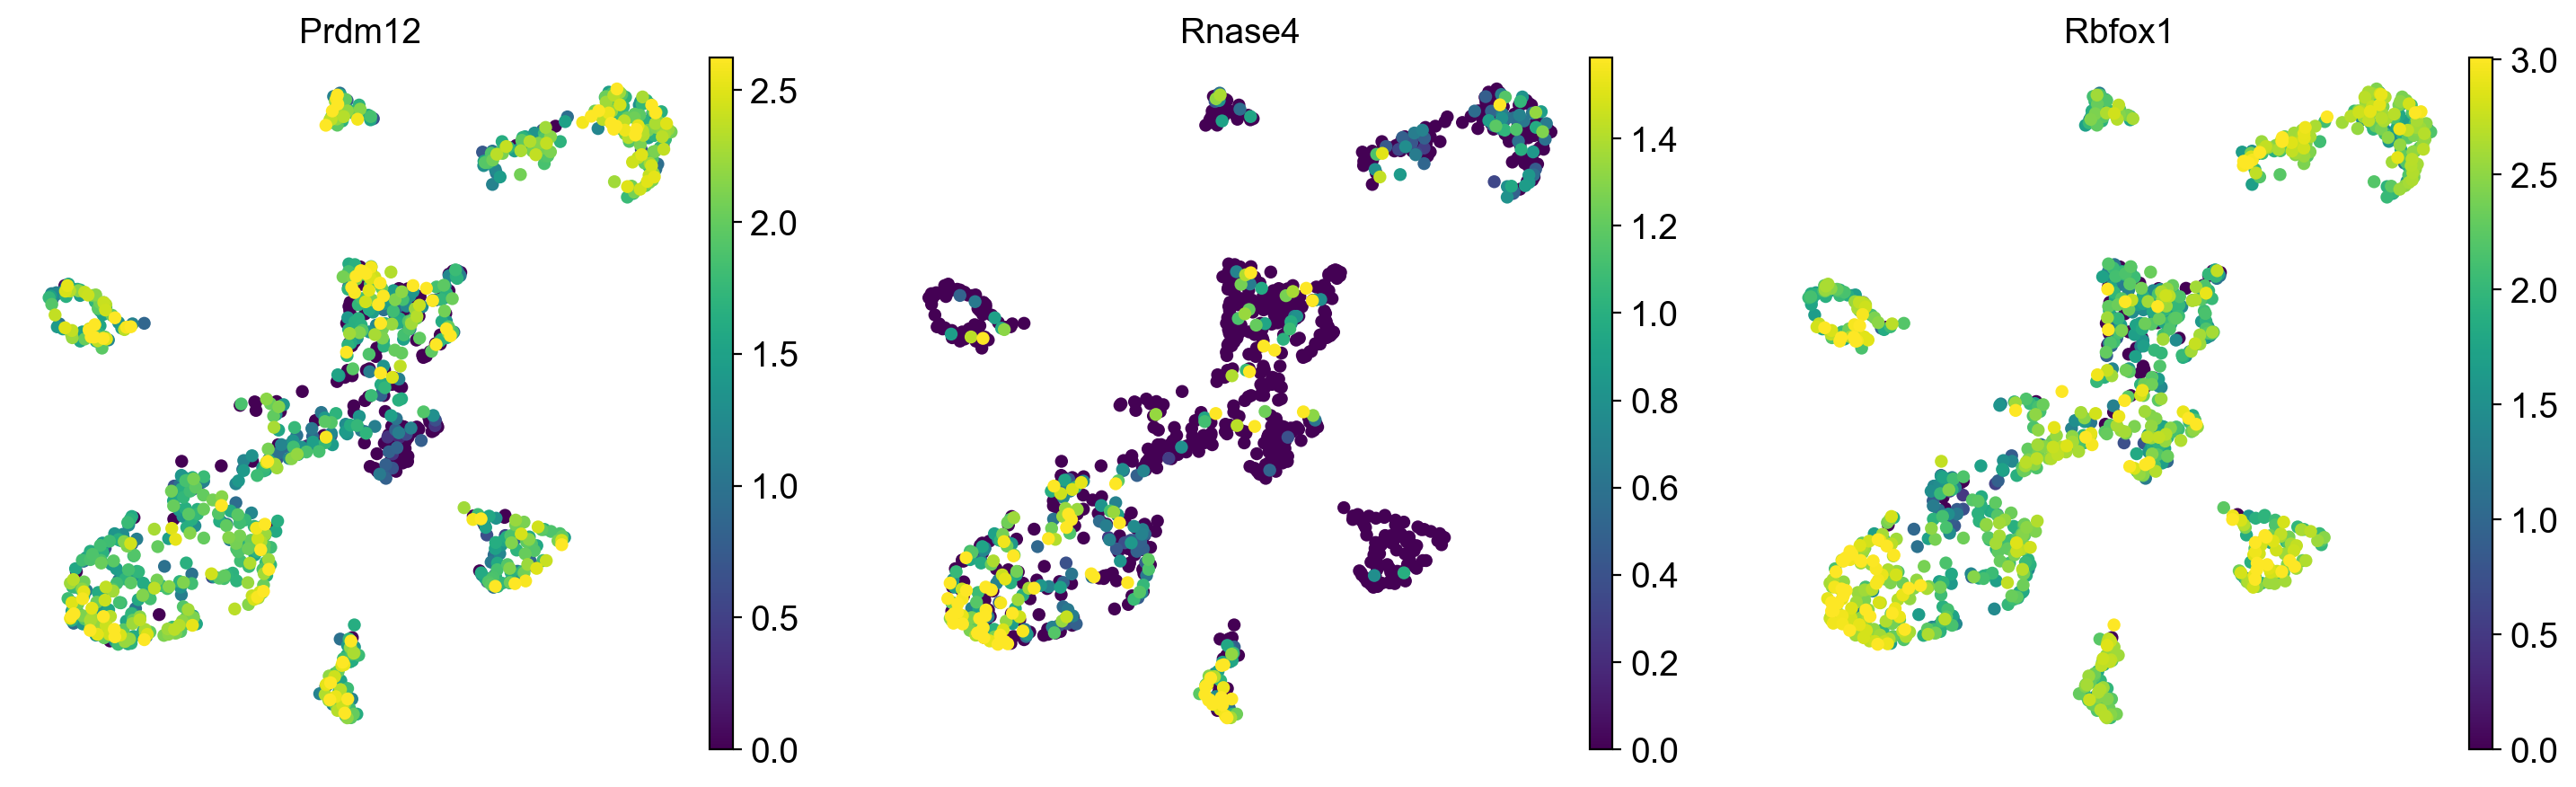

In [20]:
sc.pl.umap(adata_drg, color=['Prdm12','Rnase4','Rbfox1'], vmax='p95')

In [ ]:
import scvi
lvae = scvi.model.SCANVI.load('./scanvi_model')

INFO     File ./scanvi_model/model.pt already downloaded                                                           


In [40]:
adata_drg.obs['Source'] = 'Lab_SS3'
adata_drg.obs['celltype_scanvi'] = 'Unknown'

In [41]:
adata_drg_scvi = adata_drg.copy()

In [53]:
scvi.model.SCANVI.prepare_query_anndata(adata_drg_scvi, reference_model=lvae)
lvae_q = scvi.model.SCANVI.load_query_data(adata_drg_scvi,lvae)

In [54]:
lvae_q.train(n_samples_per_label=30)

INFO     Training for 400 epochs.                                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/pax/miniconda3/envs/rnase4/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/pax/miniconda3/envs/rnase4/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [05:55<00:00,  1.18it/s, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.12e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [05:55<00:00,  1.12it/s, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.12e+3]


In [88]:
adata_drg.obs['ct_pred'] = lvae_q.predict()
adata_drg.obsm['X_scanvi'] = lvae_q.get_latent_representation()

In [263]:
lvae_q.save('./scanvi_query', save_anndata=True)

In [89]:
sc.pp.neighbors(adata_drg, use_rep='X_scanvi', metric='cosine')
sc.tl.umap(adata_drg, min_dist=0.3)

In [ ]:
adata_drg.X = adata_drg.layers['log_norm'].copy()
adata_drg.write_h5ad('./Results/07_ss3_baf_prdm.h5ad', compression='gzip')

# DEA Nociceptors of Baf53Cre vs WT

In [4]:
bafwt_adtata = adata_drg[adata_drg.obs.Strains.isin(['BafCreRnase4ff','WT'])].copy()
bafwt_adtata = bafwt_adtata[bafwt_adtata.obs.ct_pred.isin(['PEP1','PEP2','NP','SST','cLTMR1','p_cLTMR2'])].copy()
bafwt_adtata.obs.Strains = bafwt_adtata.obs.Strains.cat.reorder_categories(['WT','BafCreRnase4ff'])

In [ ]:
from decoupler import get_pseudobulk
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [ ]:
bafwt_adtata.X = bafwt_adtata.layers['umi'].todense()
baf_adata = get_pseudobulk(bafwt_adtata, 'Description_edit', 'ct_pred', min_prop=0.1)
sc.pp.filter_genes(baf_adata, min_cells=3)

In [6]:
sc.pp.neighbors(bafwt_adtata, use_rep='X_scanvi', metric='cosine')
sc.tl.umap(bafwt_adtata, min_dist=0.3)

In [7]:
senmayo = pd.read_excel('./SenMayo.xlsx', sheet_name=1).iloc[:,0].unique().tolist()

In [ ]:
sc.tl.score_genes(adata=bafwt_adtata, gene_list=senmayo, score_name='SenMayo', use_raw=False, ctrl_size=len(senmayo))

In [16]:
bafwt_adtata.obs['SenMayo_zscore'] = stats.zscore(bafwt_adtata.obs.SenMayo).clip(-3,3)

In [13]:
sk_color = {
 'NF1': '#ffd900',
 'NF2': '#ff8c00',
 'NF3': '#ff4040',
 'NP': '#67cd00',
 'PEP1': '#87cefa',
 'PEP2': '#1c86ee',
 'SST': '#104e8b',
 'cLTMR1': '#98f5ff',
 'p_cLTMR2': '#00ced1',
 'NFs': '#104e8b',
 'Nociceptors': '#ff8c00'
 }

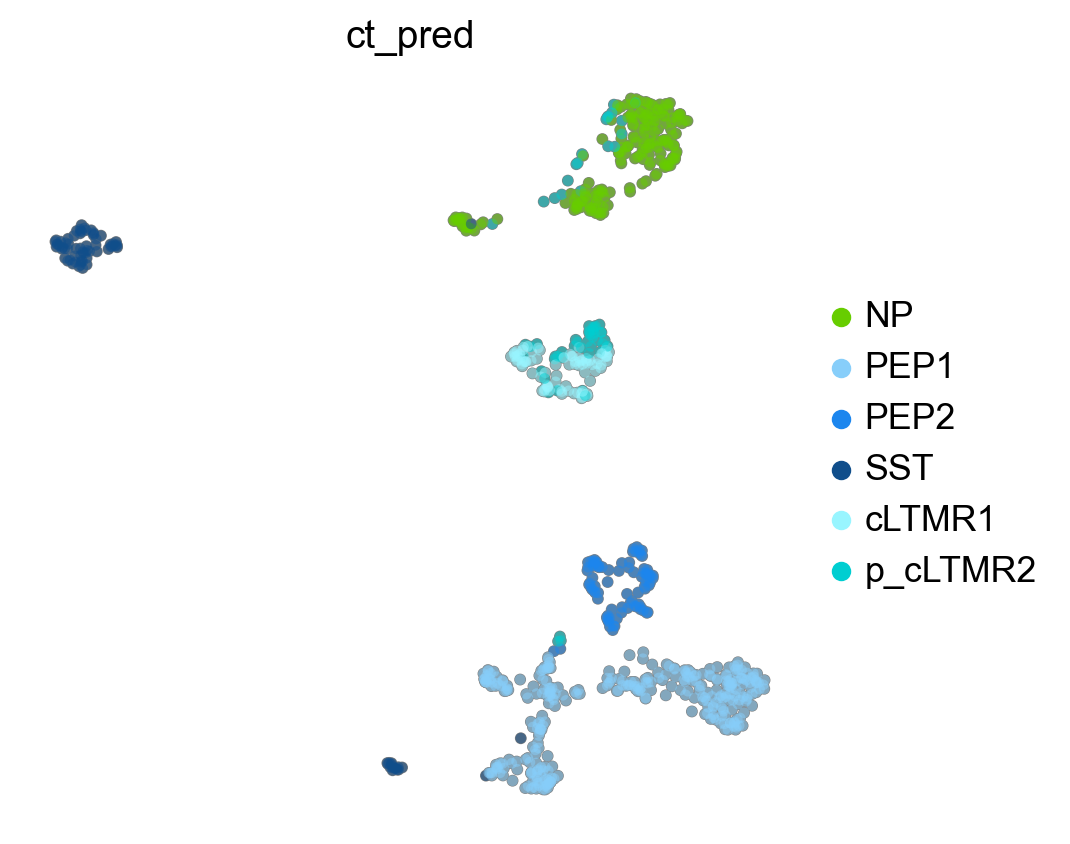

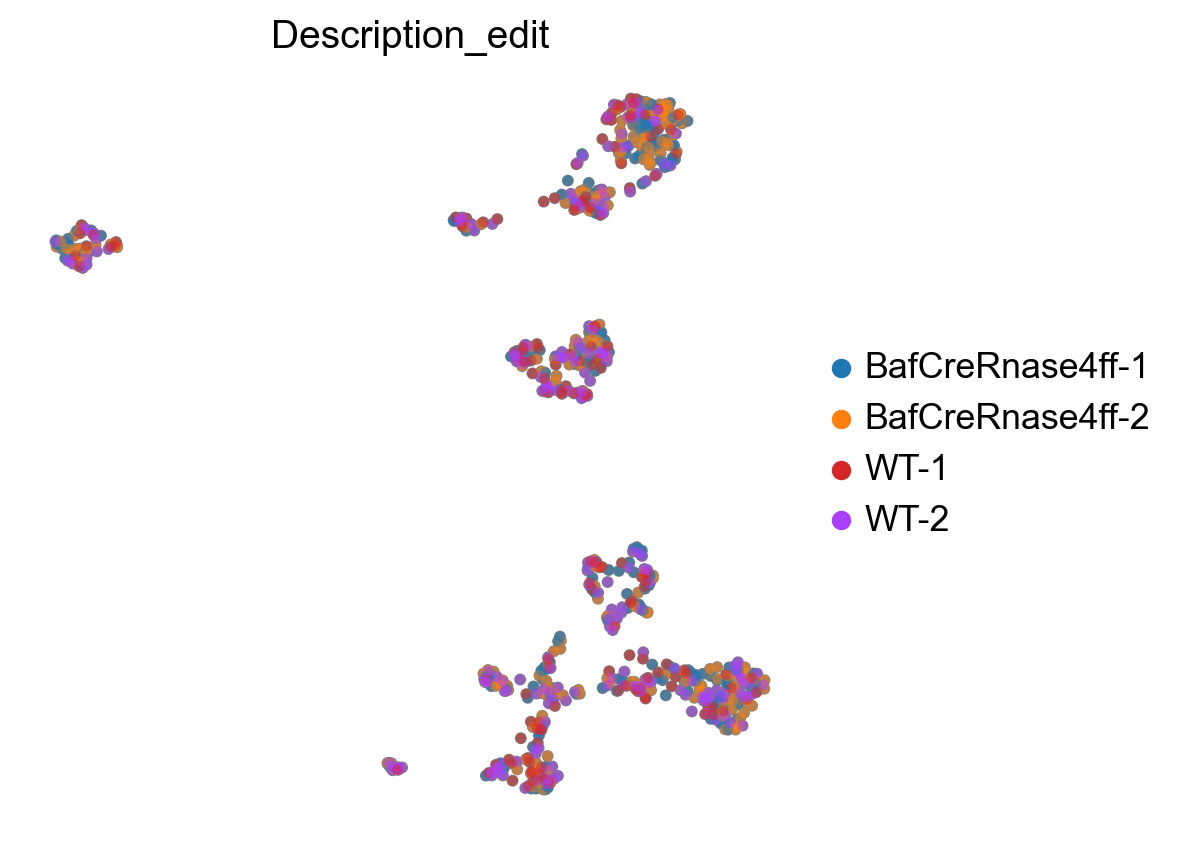

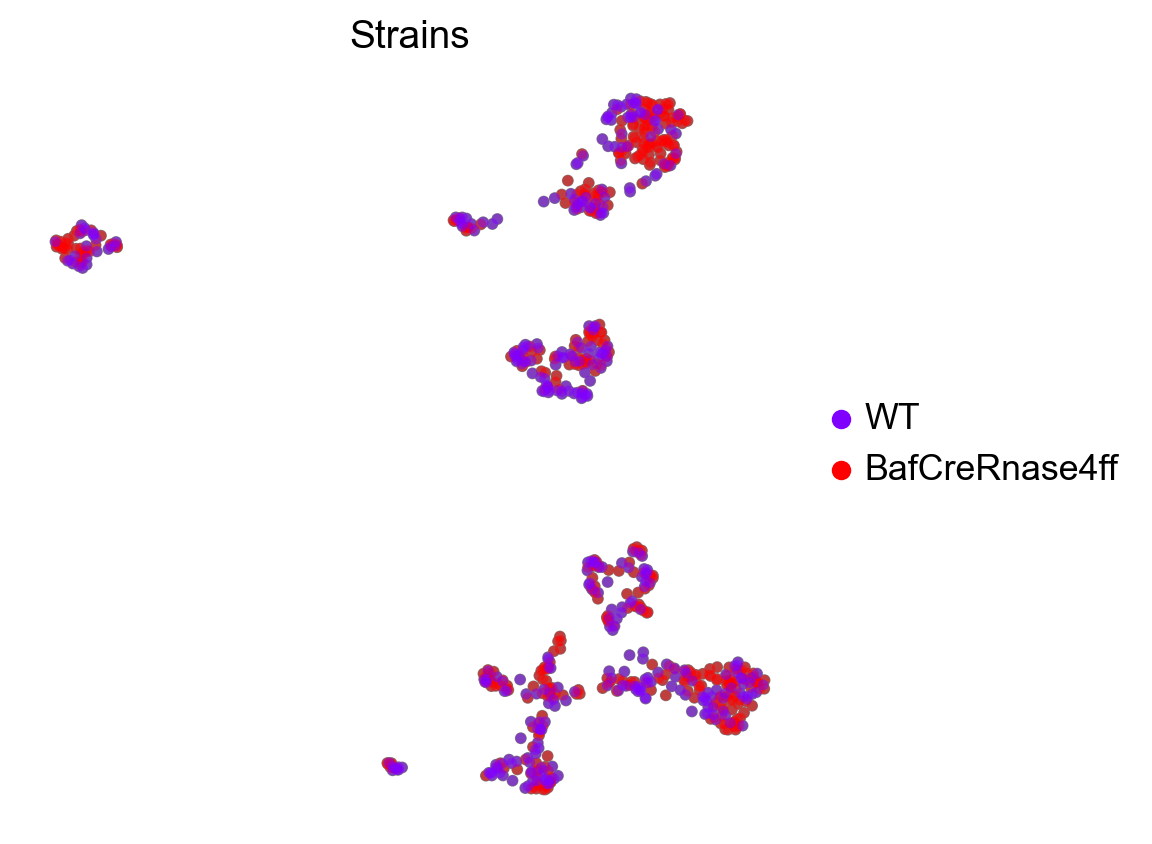

In [71]:
sc.pl.umap(bafwt_adtata, color=['ct_pred'], size=60 , palette=sk_color, alpha=0.5, legend_fontoutline=2,
           add_outline=True, outline_color=('white','grey'), outline_width=(0, 0.05), save='_bafwt_noci_ct_pred_new_params.pdf')
sc.pl.umap(bafwt_adtata, color=['Description_edit'], size=60, alpha=0.5, legend_fontoutline=2,
           add_outline=True, outline_color=('white','grey'), outline_width=(0, 0.05), save='_bafwt_noci_descrip_new_params.pdf')
sc.pl.umap(bafwt_adtata, color=['Strains'], size=60, alpha=0.5, legend_fontoutline=2, palette='rainbow',
           add_outline=True, outline_color=('white','grey'), outline_width=(0, 0.05), save='_bafwt_noci_strains_new_params.pdf')

In [22]:
bafwt_adtata.X = bafwt_adtata.layers['log_norm'].copy()

In [26]:
del bafwt_adtata.layers['umi']
del bafwt_adtata.layers['read']

In [ ]:
bafwt_adtata.write_h5ad('./Results/07_ss3_wtbaf.h5ad', compression='gzip')

In [373]:
dds = DeseqDataSet(adata = baf_adata, design_factors=['Strains'], n_cpus=8, quiet=True)
dds.deseq2()
stat_res = DeseqStats(dds, contrast=('Strains', 'BafCreRnase4ff', 'WT'), quiet=True)
stat_res.summary()
de_noci = stat_res.results_df.sort_values('stat', ascending = False)

/Users/pax/miniconda3/envs/rnase4/lib/python3.11/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
Fitting dispersions...
... done in 0.03 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.03 seconds.

/Users/pax/miniconda3/envs/rnase4/lib/python3.11/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


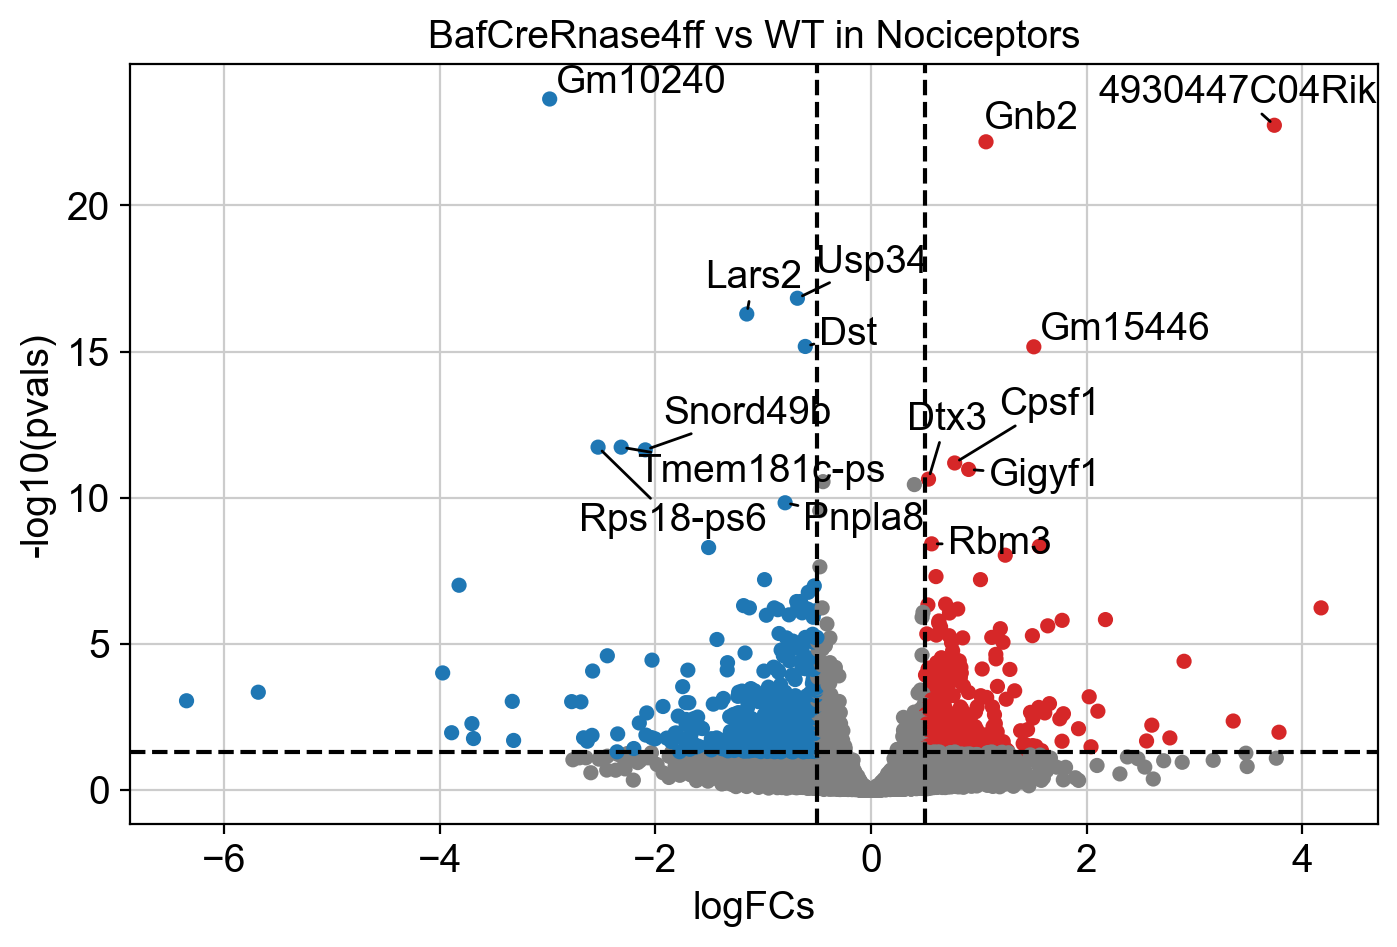

In [ ]:
fig,ax = plt.subplots(figsize=(8,5))
plot_volcano_df(de_noci, 'log2FoldChange', 'padj', top=15, ax=ax)
ax.set_title('BafCreRnase4ff vs WT in Nociceptors')
fig.savefig('./figures/07_baf_vs_wt_in_noci.pdf', bbox_inches='tight')

In [ ]:
de_noci.to_excel('./tables/07_BafCreRnase4ff_de_noci.xlsx')

In [ ]:
de_noci_filter = de_noci[(de_noci.padj < 0.05) & (de_noci.log2FoldChange.abs() > 0.5)].copy()
de_noci_filter.to_excel('./tables/07_BafCreRnase4ff_de_noci_filter.xlsx')

In [152]:
import gseapy as gp
from tqdm import tqdm
def get_enrich(df_, n_top=100, gset='GO_Biological_Process_2023'):
    up = df_.sort_values('log2FoldChange', ascending=False).loc[lambda x: x.log2FoldChange > 0].head(n_top).index.tolist()
    down = df_.sort_values('log2FoldChange', ascending=True).loc[lambda x: x.log2FoldChange < 0].head(n_top).index.tolist()
    enr_up = gp.enrichr(up, gene_sets=gset,outdir=None)
    enr_down = gp.enrichr(down, gene_sets=gset,outdir=None)
    enr_up.res2d.Term = enr_up.res2d.Term.str.split(" \(GO").str[0]
    enr_down.res2d.Term = enr_down.res2d.Term.str.split(" \(GO").str[0]
    enr_up.res2d['UP_DW'] = "UP"
    enr_down.res2d['UP_DW'] = "DOWN"
    enr_res = pd.concat([enr_up.res2d, enr_down.res2d])
    return enr_res

In [ ]:
noci_enr = get_enrich(de_noci_filter)
noci_enr.to_excel('./tables/BafCreRnase4ff_gsea_noci.xlsx')

In [ ]:
ax = gp.dotplot(noci_enr,figsize=(3,4),
                x='UP_DW',
                x_order = ["UP","DOWN"],
                title='BafCreRnase4ff in Nociceptors',
                cmap = 'RdBu_r',
                size=10,
                show_ring=True,
                )
ax.set_xlabel("")
ax.grid(axis='x')
plt.savefig(f'./figures/07_nociceptor_gsea.pdf', bbox_inches='tight')

In [9]:
markers = ['Trpm6', 'Kcnf1', 'Nrg3', 'Hcn3', 'Scn9a', 'Kcng3', 'Rela', 'Map1a', 'Map1b']

In [56]:
bafwt_adtata.X = bafwt_adtata.layers['log_norm'].copy()

In [63]:
def stack_vln(adata:sc.AnnData, markers:list, groupby:str, layer:str, figsize:tuple=(3.5,6), pad:float=-0.5, **kwds):
    fig, ax = plt.subplots(len(markers),1, figsize=figsize)
    ax = ax.ravel()
    for i,g in enumerate(markers):
        sc.pl.violin(adata, keys=g, groupby=groupby,layer=layer, ax=ax[i], show=False, **kwds)
        ax[i].grid(False)
        ax[i].set_ylim(0, 6)
        if i+1 < len(markers):
            ax[i].set_xlabel('')
            ax[i].set_xticks([])
    fig.tight_layout(pad=pad)
    return fig, ax

In [ ]:
for s in bafwt_adtata.obs.Strains.cat.categories:
    fig, ax = stack_vln(bafwt_adtata[bafwt_adtata.obs.Strains == s], markers, groupby='ct_pred',
                        layer=None, stripplot=True, jitter=True, rotation=90, pad=-0.55, palette=sk_color)
    ax[0].set_title(s)
    fig.savefig(f'./figures/07_violin_{s}_markers_new_params.pdf', bbox_inches='tight')